# Clustering - Tuto 0

In this 1st tuto, we simply play with KMeans and GMM on a toy multimodal dataset

The objective is to illustrate a "clustering" method

In [1]:
# Libraries import section
import os

import xarray as xr
import numpy as np
from scipy import stats
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

import pandas as pd

import seaborn as sns
sns.set(context="notebook", style="whitegrid", palette="deep", color_codes=True)

In [2]:
# Usefull functions

# Trivial functions to create and manipulate 2D matrices [n_samples,n_features=2]

def new_sample(m,s,n=100,r=170):
    """Return a 2D normal distribution centered on m with std s"""
    X, y = make_blobs(n_samples=n, random_state=r, centers=[m], cluster_std=s)
    return {'data':X,'labels':y}

def stretch(X,m=[1,1]):
    """Stretch a 2d matrix X by factors m[0] and m[1] along dimemsions 0 and 1"""
    return np.dot(X, [[m[0], 0], [0, m[1]]])

def rotate(X,a=0):
    """Rotate around the origin a 2d matrix X by angle a in degrees"""
    a = np.deg2rad(a) # Convert degrees to radians
    return np.dot(X, [[np.cos(a), np.sin(a)], [-np.sin(a), np.cos(a)]])

def translate(X,v=[0,0]):
    """Translate 2d matrix X by v[0] and v[1] along dimemsions 0 and 1"""
    n = X.shape[0]
    X[:,0] += np.full((n),v[0])
    X[:,1] += np.full((n),v[1])
    return X

# More functions
def vrange(V):
    """Return the array value range"""
    return [np.min(V),np.max(V)]
def vrangec(V):
    """"Return the array value centered range"""
    xl = np.max(np.abs(vrange(V)))
    return np.array([-xl,xl])


# Plotting functions

def plot2d_labels(X,labels,cluster_centers=np.empty(()),dpi=80):
#     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=plt.figaspect(0.6), dpi=90, facecolor='w', edgecolor='k')
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10), dpi=dpi, facecolor='w', edgecolor='k')

    unique_labels = np.unique(labels)
    n_clusters_ = unique_labels.shape[0]
    colors = sns.husl_palette(n_clusters_)

    for k, col in zip(range(n_clusters_), colors):
        class_members = labels == k

        plt.plot(X[class_members,0], X[class_members,1], '.', 
                 markerfacecolor=tuple(col), markeredgecolor='none', label='Class %i'%(k))

        if len(cluster_centers.shape)>0:
            plt.plot(cluster_centers[k,0], cluster_centers[k,1], 'X', markerfacecolor=tuple(col),
                     markeredgecolor='k', markersize=10, label='Class center #%i'%(k))

    plt.axis('equal')
    plt.title('Number of clusters: %i' % n_clusters_)
    plt.legend()
    return fig, ax, colors

def plot_GMMellipse(gmm,ik,col,ax,label="",std=[1],main_axes=True,**kwargs):
    """
        Plot an 1-STD ellipse for a given component (ik) and 2 given dimensions (id) 
        of the GMM model gmm
        This is my routine, simply working with a matplotlib plot method
        I also added the possiblity to plot the main axes of the ellipse
    """
    id = [0,1] # Dimensions id
    covariances = gmm.covariances_[ik][(id[0],id[0],id[1],id[1]),(id[0],id[1],id[0],id[1])].reshape(2,2)
    d, v = np.linalg.eigh(covariances) #  eigenvectors have unit length
    d = np.diag(d)
    theta = np.arange(0,2*np.pi,0.02)
    x = np.sqrt(d[0,0])*np.cos(theta)
    y = np.sqrt(d[1,1])*np.sin(theta)
    xy = np.array((x,y)).T
    ii = 0
    for nstd in np.array(std):
        ii+=1
        ellipse = np.inner(v,xy).T
        ellipse = nstd*ellipse + np.ones((theta.shape[0], 1))*gmm.means_[ik,(id[0],id[1])]
        if ii == 1:
    #            p = ax.plot(ellipse[:,0], ellipse[:,1], color=col, axes=ax, label=("%s (%i-std)")%(label,nstd),**kwargs)
            p = ax.plot(ellipse[:,0], ellipse[:,1], color=col, axes=ax, label=("%s")%(label),**kwargs)
        else:
            p = ax.plot(ellipse[:,0], ellipse[:,1], color=col, axes=ax,**kwargs)
    if main_axes: # Add Main axes:
        for idir in range(2):
            l = np.sqrt(d[idir,idir])*v[:,idir].T
            start = gmm.means_[ik,(id[0],id[1])]-l
            endpt = gmm.means_[ik,(id[0],id[1])]+l
            linex = [start[0], endpt[0]]
            liney = [start[1], endpt[1]]
            plt.plot(linex,liney,color=col,axes=ax,**kwargs)
    return p, ax

def sns_GMMellipse(x,y,gmm=[],std=[1],main_axes=True,label="?",colors=None,**kwargs):
    """
        Same as plot_GMMellipse but works in Seaborn join plots
    """
    id = [0,1] # Dimensions
    K = gmm.n_components
#    colors = iter(plt.cm.rainbow(np.linspace(0, 1, K)))
#     colors = sns.color_palette("Paired", K)
    for ik in np.arange(K):
#        col = next(colors)
        col = colors[ik]
        covariances = gmm.covariances_[ik][(id[0],id[0],id[1],id[1]),(id[0],id[1],id[0],id[1])].reshape(2,2)
        d, v = np.linalg.eigh(covariances) #  eigenvectors have unit length
        d = np.diag(d)
        theta = np.arange(0,2*np.pi,0.02)
        x = np.sqrt(d[0,0])*np.cos(theta)
        y = np.sqrt(d[1,1])*np.sin(theta)
        xy = np.array((x,y)).T
        ii = 0
        for nstd in np.array(std):
            ii+=1
            ellipse = np.inner(v,xy).T
            ellipse = nstd*ellipse + np.ones((theta.shape[0], 1))*gmm.means_[ik,(id[0],id[1])]
            if ii == 1:
                plt.plot(ellipse[:,0], ellipse[:,1], color=col, label=("%s")%(label),**kwargs)
            else:
                plt.plot(ellipse[:,0], ellipse[:,1], color=col, **kwargs)
        if main_axes: # Add Main axes:
            for idir in range(2):
                l = np.sqrt(d[idir,idir])*v[:,idir].T
                start = gmm.means_[ik,(id[0],id[1])]-l
                endpt = gmm.means_[ik,(id[0],id[1])]+l
                linex = [start[0], endpt[0]]
                liney = [start[1], endpt[1]]
                plt.plot(linex,liney,color=col)

Text(0.5,1,'True 4 clusters')

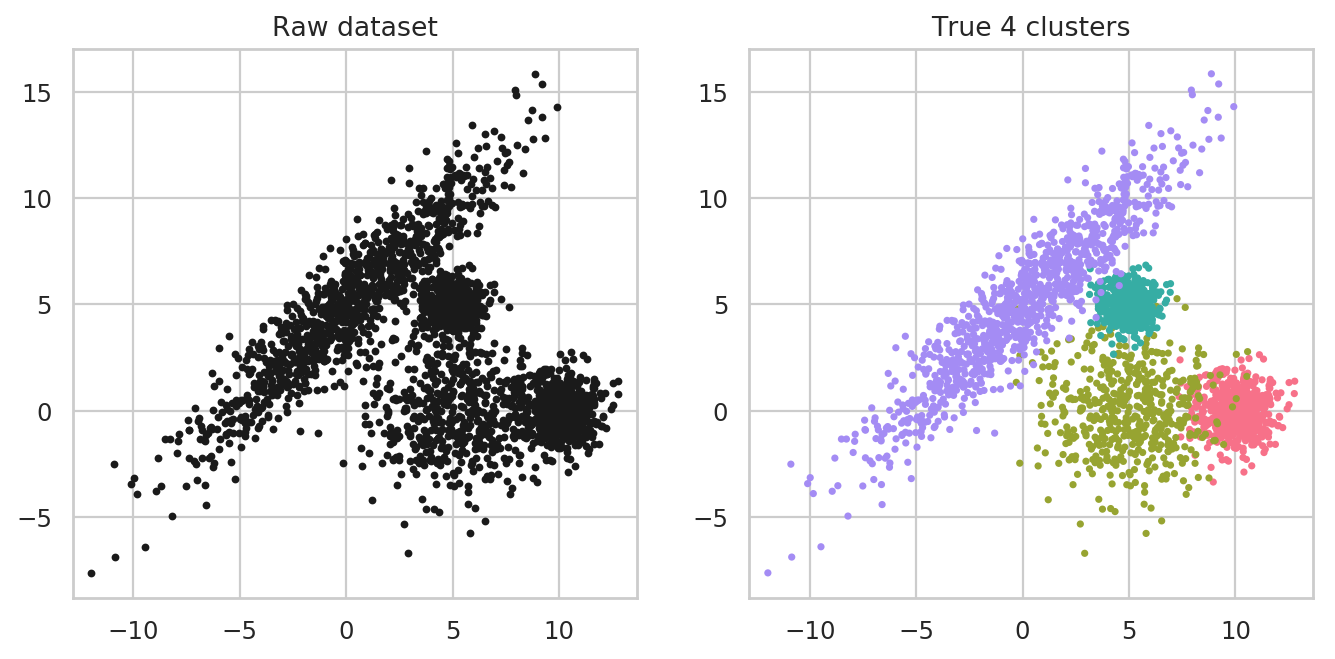

In [3]:
# Create a 2D sample datasets with Normal distributions
# Dataset is in "X", true labels in "y"

n = 500 # Number of samples per cluster

il = 0 # Init cluster IDs
s = new_sample([10,0],1,n=n)
X, y = s['data'], s['labels'] # 1st label is "0"

il += 1
X, y = np.concatenate((X,new_sample([5,0],2,n=n)['data']),axis=0), np.concatenate((y,np.full((n),il)),axis=0)

il += 1
X, y = np.concatenate((X,new_sample([5,5],0.7,n=n)['data']),axis=0), np.concatenate((y,np.full((n),il)),axis=0)

il += 1
x = translate(rotate(stretch(new_sample([0,0],1,n=2*n)['data'],m=[5,1]),a=45),v=[0,5])
X, y = np.concatenate((X,x),axis=0), np.concatenate((y,np.full((2*n),il)),axis=0)

n_clusters_true = il+1

plt.figure(figsize=(10,10), dpi=160, facecolor='w', edgecolor='k')
plt.subplot(221)
plt.plot(X[:, 0], X[:, 1],'k.',markersize=5)
plt.axis('equal')
plt.title("Raw dataset")
plt.subplot(222)
plt.scatter(X[:, 0], X[:, 1], 5, c=y, cmap=ListedColormap(sns.husl_palette(n_clusters_true).as_hex()))
plt.axis('equal')
plt.title("True %i clusters"%n_clusters_true)

In [4]:
# Clustering with KMeans
kmeans = KMeans(n_clusters=n_clusters_true, random_state=0).fit(X)
labels = kmeans.predict(X)
n_clusters_ = kmeans.n_clusters
print kmeans.cluster_centers_.shape
print kmeans.cluster_centers_

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

(4, 2)
[[ 9.77864348e+00 -3.82636373e-03]
 [-2.62757661e+00  2.31832527e+00]
 [ 4.03064181e+00  6.36914659e+00]
 [ 4.60875170e+00 -3.13388057e-01]]
Silhouette Coefficient: 0.493


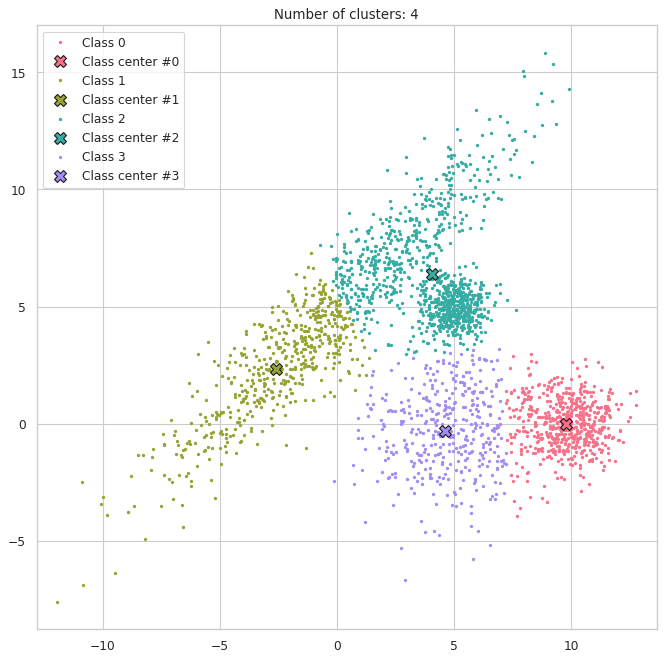

In [5]:
fig, ax, colors = plot2d_labels(X,labels,cluster_centers=kmeans.cluster_centers_)

In [6]:
# Clustering with GMM
gmm = GMM(n_components=n_clusters_true, random_state=0).fit(X)
labels = gmm.predict(X)
n_clusters_ = gmm.n_components
# print gmm.means_
# print gmm.covariances_

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Silhouette Coefficient: 0.347


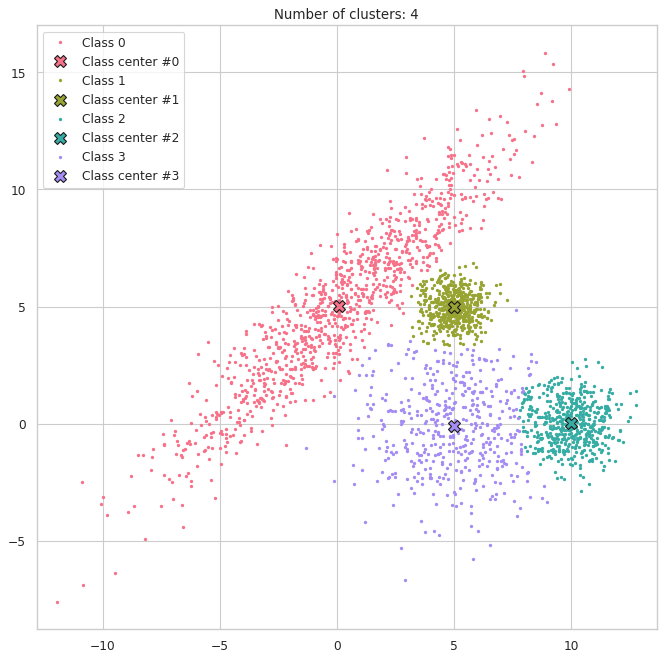

In [7]:
fig, ax, colors = plot2d_labels(X,labels,cluster_centers=gmm.means_)

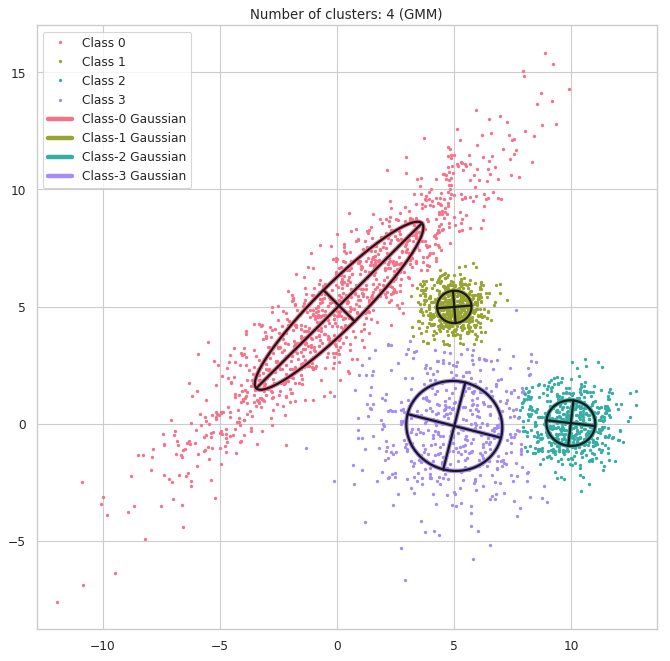

In [8]:
fig, ax, colors = plot2d_labels(X, labels, dpi=80)

for k, col in zip(range(n_clusters_), colors):
    el,ax = plot_GMMellipse(gmm,k,col,ax,label="Class-%i Gaussian"%(k),linewidth=4)
    el,ax = plot_GMMellipse(gmm,k,'k',ax,linewidth=2)
    
ax.axis('equal')
plt.title('Number of clusters: %i (GMM)' % n_clusters_)
plt.legend()
plt.show()

/home1/datahome/gmaze/conda-env/lopsformationdata/lib/python2.7/site-packages/seaborn/axisgrid.py:1672: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/home1/datahome/gmaze/conda-env/lopsformationdata/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home1/datahome/gmaze/conda-env/lopsformationdata/lib/python2.7/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'kind'
  s)
/home1/datahome/gmaze/conda-env/lopsformationdata/lib/python2.7/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not

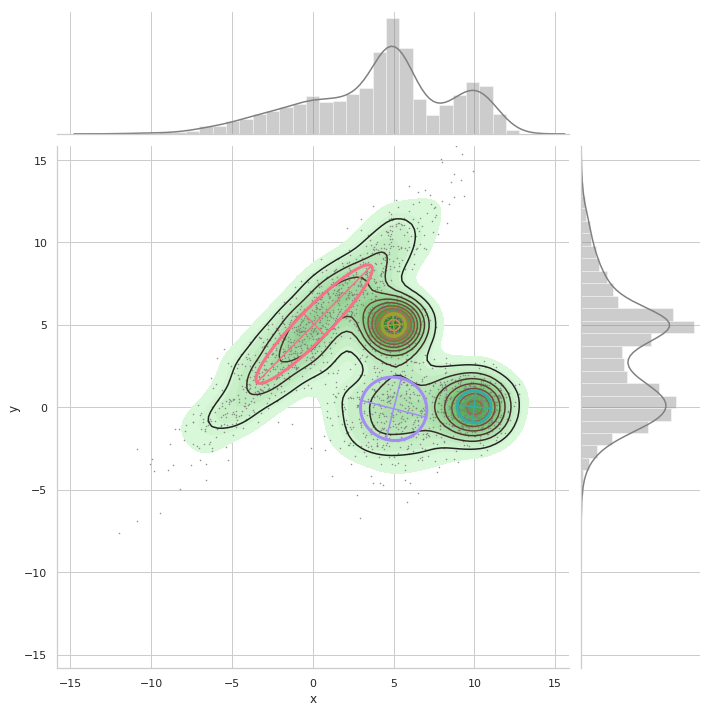

In [9]:
# df = pd.DataFrame(X, columns=["x", "y"])
df = pd.DataFrame(np.concatenate((X,labels[np.newaxis].T),axis=1), columns=["x", "y", "labels"])
g = sns.JointGrid(x="x", y="y", data=df, size=10, ratio=4, space=0.1,
                  xlim=vrangec(X),ylim=vrangec(X))

# cmap = sns.light_palette("gray",reverse=False,as_cmap=True)
cmap = sns.light_palette("green",as_cmap=True)
g.plot_joint(sns.kdeplot, kernel='gau', shade = True, \
                 shade_lowest=False,\
                 cmap=cmap, kind='hex', n_levels=30)
g.plot_joint(sns.kdeplot, kernel='gau', shade = False, kind='hex', n_levels=10, linewidth=0.5)

g.plot_marginals(sns.distplot, kde=True, color=".5")

g.plot_joint(plt.scatter, c=".5", s=1, linewidth=1, marker=".")

g.plot_joint(sns_GMMellipse, gmm=gmm, main_axes=True, linewidth=3, colors=colors)


In [10]:
# df = pd.DataFrame(np.concatenate((X,labels[np.newaxis].T),axis=1), columns=["x", "y", "labels"])

# g = sns.PairGrid(df, hue="labels", vars=["x","y"], palette=colors, height=5)
# # g.map_diag(sns.kdeplot,shade=True)
# g.map_diag(sns.kdeplot,shade=True, kernel='gau')
# # g.map_offdiag(plt.scatter)
# g.map_lower(plt.scatter)
# g = g.add_legend()

# # sns.pairplot(df, vars=["x","y"], markers='.', kind='scatter', hue='labels', palette=colors, height=5)
# # sns.pairplot(df,markers='.',kind='reg')
# # g.map_diag(sns.kdeplot, kernel='gau')

# Now plot "membership" statistics

In [14]:
POST = gmm.predict_proba(X) # [Np,Nc]
print X.shape
print POST.shape

(2500, 2)
(2500, 4)


IndexError: index 4 is out of bounds for axis 1 with size 4

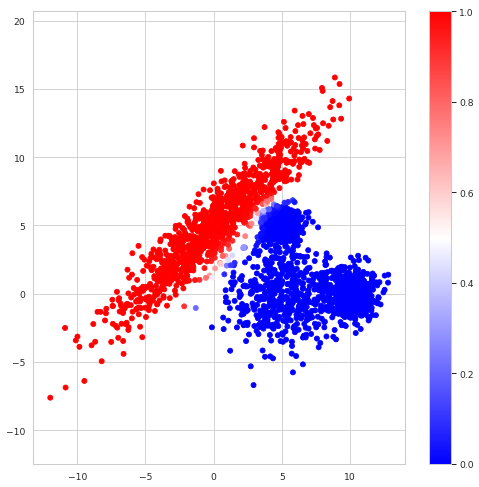

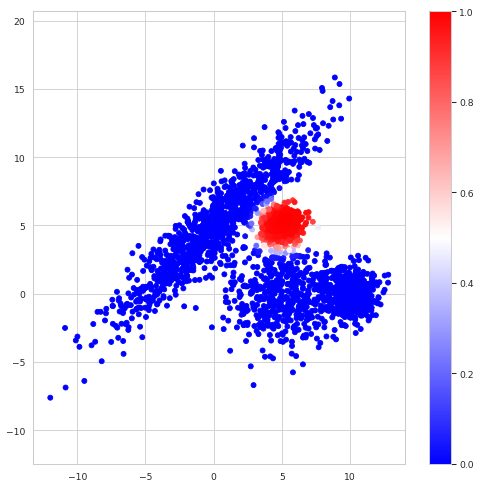

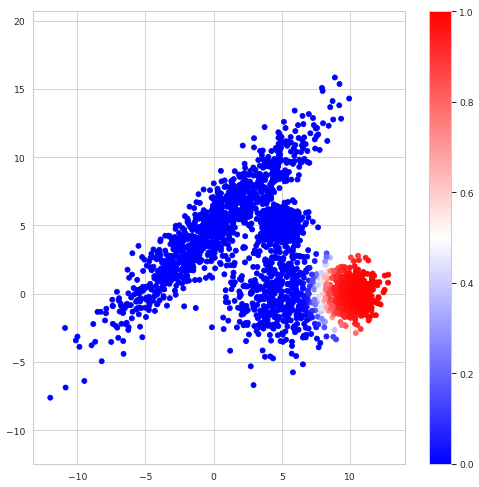

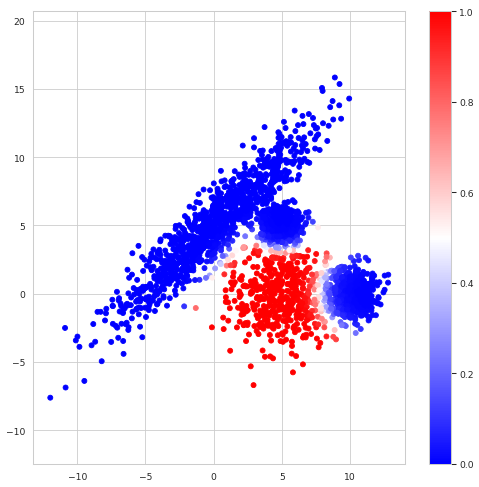

In [37]:
def plot2d_probs(X,prob,cluster_centers=np.empty(()),dpi=60):
#     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=plt.figaspect(0.6), dpi=90, facecolor='w', edgecolor='k')
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10), dpi=dpi, facecolor='w', edgecolor='k')
    plt.scatter(X[:,0], X[:,1], c=prob, cmap=plt.cm.get_cmap('bwr'), vmin=0, vmax=1)
#         if len(cluster_centers.shape)>0:
#             plt.plot(cluster_centers[k,0], cluster_centers[k,1], 'X', markerfacecolor=tuple(col),
#                      markeredgecolor='k', markersize=10, label='Class center #%i'%(k))
    plt.axis('equal')
    plt.colorbar()
    return fig, ax

for k in np.arange(POST.shape[0]-1):
    fig, ax = plot2d_probs(X,POST[:,k])